# Data shift

In [6]:
subject=11
ppg_name="cppg" # rppg
sr=255 # 255 or 30
start=30000 # 30000 (c: frame_time->msec) or 30(r: group->sec)
length=153000 #데이터 개수 rppg : 18000, cppg : 153000 

path="D:\\prlab\\ysg\\rppg\\rppg_HRV\\data\\%s\\%s%d.csv"%(ppg_name,ppg_name,subject)
ppg = pd.read_csv(path,header=None)
ppg=ppg.transpose()

# # RPPG
# ppg.columns=['hr','time','group']
# group=pd.to_numeric(ppg['group'])
# group=group[group>=start].index[0] # group이 초와 같음.
# cut_ppg=ppg[group:group+length] # 18000/30 = 600초(10분)

# CPPG
ppg.columns=['hr','real_time','frame_time']
group=pd.to_numeric(ppg['frame_time'])
group=group[group>=start].index[0] # group이 초와 같음.
cut_ppg=ppg[group:group+length] # 18000/30 = 600초(10분)
#cut_ppg=ppg[(sr * 30) : sr * 630]


# 공통코드
print("before : ", len(ppg))
print(ppg)
print(cut_ppg)
print("after: ",len(cut_ppg)) # 10분

t1=0
t2=sr*300
#print(t1,t2) # 5분 -> 300초 ->데이터 9000개
for i in range(len(cut_ppg)):
    new_ppg=cut_ppg[t1:t2].transpose()
    new_ppg.to_csv("D:\\prlab\\ysg\\rppg\\rppg_HRV\\data\\%s\\shift\\%d\\%s%d_%d.csv" %(ppg_name,subject,ppg_name,subject,i),header=False,index=False)
    t1=t1+(30*sr) # 30chift (30초 더한 index 구하기 30*sr)
    t2=t2+(30*sr)
    print("shift index: ",t1,t2) # RPPG : 9000간격((9000/30)/60 >> 5분)
    if t2>len(cut_ppg):
        break
    print('data shifting : ',str(subject)+'_'+str(i))

before :  168300
          hr                   real_time          frame_time
0       1813  2021-06-17 13:24:49.513937                 0.0
1       1806  2021-06-17 13:24:49.517933  3.9958953857421875
2       1803  2021-06-17 13:24:49.522112   8.174896240234375
3       1799  2021-06-17 13:24:49.525935   11.99793815612793
4       1795  2021-06-17 13:24:49.529934  15.996932983398438
...      ...                         ...                 ...
168295  3376  2021-06-17 13:35:49.420502    659906.564950943
168296  3344  2021-06-17 13:35:49.424307   659910.3701114655
168297  3306  2021-06-17 13:35:49.428087   659914.1499996185
168298  3266  2021-06-17 13:35:49.431659   659917.7219867706
168299  3223  2021-06-17 13:35:49.435620   659921.6830730438

[168300 rows x 3 columns]
          hr                   real_time          frame_time
7649    2172  2021-06-17 13:25:19.516503   30002.56609916687
7650    2170  2021-06-17 13:25:19.520442  30006.505012512207
7651    2167  2021-06-17 13:25:19.524459 

# hrv graph 시각화

In [1]:
import os
import heartpy as hp
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy import signal
import csv
import math
from hrvanalysis import get_frequency_domain_features, get_time_domain_features
from utils import *
import pandas as pd
import sys
from scipy.interpolate import interp1d
import matplotlib as mlp

## csv파일 불러오기


In [2]:
# 그래프 확인하기
subject=0
num=0

cppg_frequency_features=[]
rppg_frequency_features=[]

#path_rppg="D:\\prlab\\ysg\\rppg\\RPPG-HRV_analysis\\data\\rppg\\rppg%d.csv"%(subject)#"D:\\prlab\\ysg\\rppg\\new\\data\\rppg\\rppg%d.csv"%(subject)
path_rppg="D:\\prlab\\ysg\\rppg\\RPPG-HRV_analysis\\data\\rppg\\shift\\%d\\rppg%d_%d.csv"%(subject,subject,num)
rppg = pd.read_csv(path_rppg,header=None)
rppg=rppg.transpose()
rppg.columns=['hr','time','group']
#rppg=rppg[(30 * 30) : (30 * 630)]
rppg_time=np.array(rppg['time'],dtype='float32')
rppg_hr=np.array(rppg['hr'],dtype='float32')


print(rppg_hr.shape)
print(rppg)

#path_cppg="D:\\prlab\\ysg\\rppg\\RPPG-HRV_analysis\\data\\cppg\\cppg%d.csv"%(subject)
path_cppg="D:\\prlab\\ysg\\rppg\\RPPG-HRV_analysis\\data\\cppg\\shift\\%d\\cppg%d_%d.csv"%(subject,subject,num)#"D:\\prlab\\ysg\\rppg\\new\\data\\cppg\\cppg%d.csv"%(subject)
cppg = pd.read_csv(path_cppg,header=None)
cppg=cppg.transpose()
cppg.columns=['hr','realtime','time']
#cppg=cppg[(255 * 30): (255 * 630)]
cppg_time=np.array(cppg['time'],dtype='float32')
cppg_hr=np.array(cppg['hr'],dtype='float32')


c_sr=255
r_sr=30

(9000,)
            hr         time  group
0     0.000668   30000.0000   30.0
1     0.000105   30033.3333   30.0
2    -0.000471   30066.6667   30.0
3    -0.001068   30100.0000   30.0
4    -0.001675   30133.3333   30.0
...        ...          ...    ...
8995  0.001358  329833.3333  329.0
8996  0.001503  329866.6667  329.0
8997  0.001573  329900.0000  329.0
8998  0.001627  329933.3333  329.0
8999  0.001701  329966.6667  329.0

[9000 rows x 3 columns]


## 신호전처리
1. band fass filtering
2. normalization
3. peak detection

### CPPG signal processing

76500


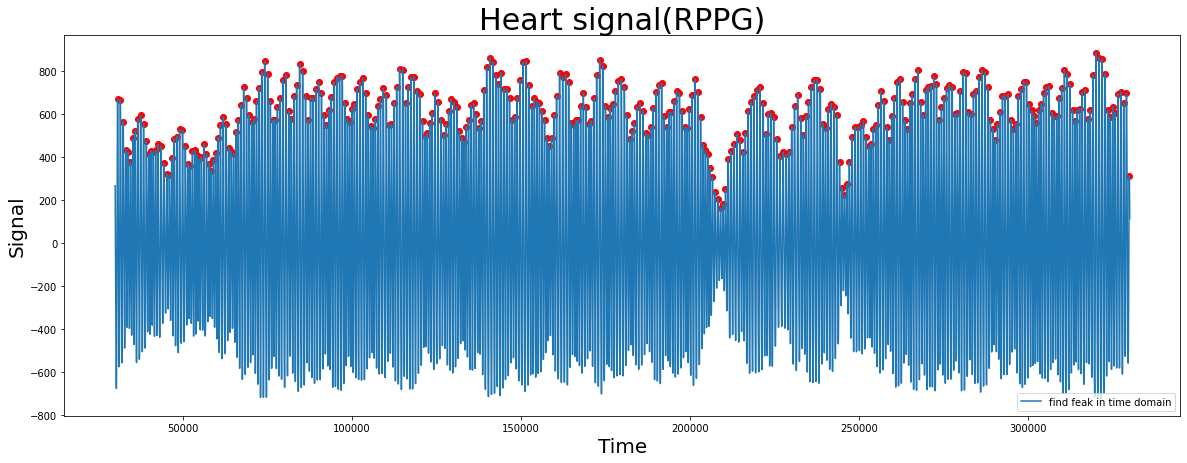

In [3]:
# 앞뒤 30초 cutting
c_distance=130

filter_c=preprocessing(cppg_hr,2.0,0.5,c_sr)
print(len(filter_c))

#print(len(scale_c))
c_peaks_y,c_peaks_x=detect_peak(cppg_time,filter_c,c_distance)

plt.figure(figsize=(20, 7))    
plt.scatter(c_peaks_x, c_peaks_y,color='red')
plt.plot(cppg_time, filter_c, label="find feak in time domain")
#plt.xlim([400000, 500000])# 30초 즉, 30000msec 씩 shift
plt.xlabel('Time',fontsize=20)
plt.ylabel('Signal',fontsize=20)
plt.title('Heart signal(RPPG)',fontsize=30)
plt.legend(loc='lower right')
mlp.rcParams["font.size"] = 20
plt.show()


### RPPG signal processing

#### with interpolation

76500
76500 76500


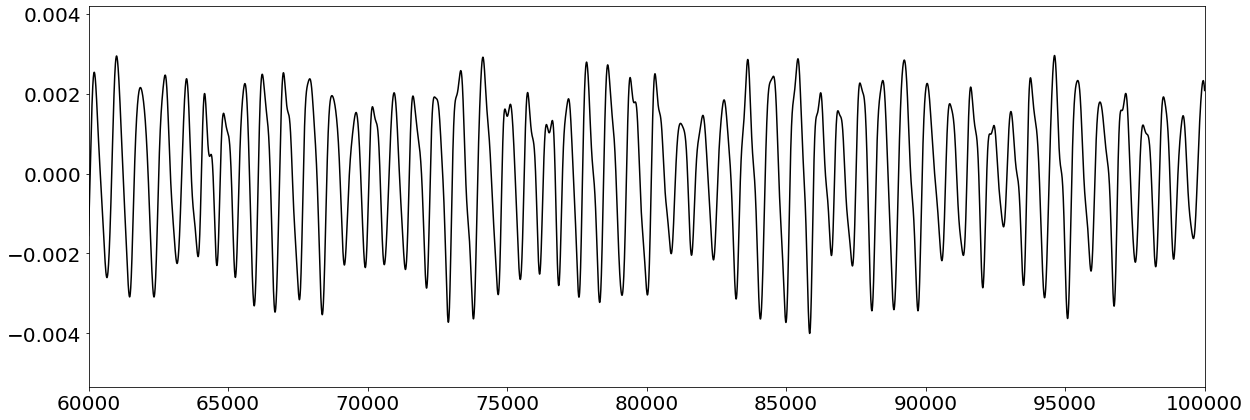

30596.01997084929


No handles with labels found to put in legend.


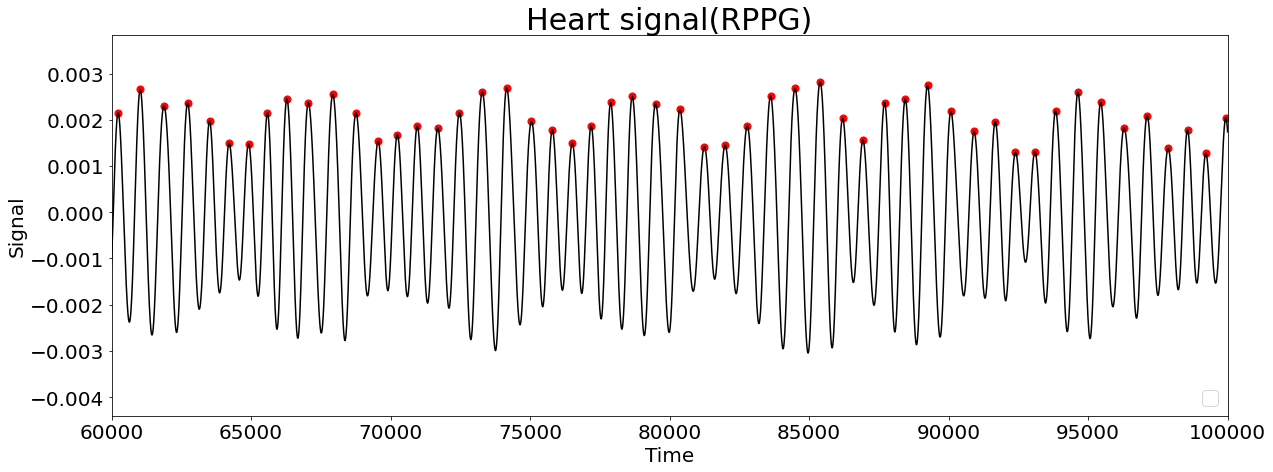

30000.0


In [4]:
# signal interpolation

x=rppg_time
print(len(cppg_time))
new_x=np.linspace(rppg_time[0],rppg_time[-1],len(cppg_time))
print(len(cppg_time),len(new_x))
i=interp1d(x,rppg_hr,kind = 'quadratic')


rppg_hr=i(new_x)
rppg_time=new_x
plt.figure(figsize=(20,7))
plt.plot(rppg_time,rppg_hr,color='black')
plt.xlim([60000,100000])# msec
plt.show()
# 앞,뒤 30초씩 cutting
r_distance=100

# signal interpolation

filter_r=preprocessing(rppg_hr,2.0,0.5,c_sr)

#scale_r=normalization(filter_r)

r_peaks_y,r_peaks_x=detect_peak(rppg_time,filter_r,r_distance)
print(r_peaks_x[0])

plt.figure(figsize=(20, 7))    
plt.scatter(r_peaks_x, r_peaks_y,s=50,color='red')
plt.plot(rppg_time,filter_r, color='black')

plt.xlim([60000,100000])# msec
plt.xlabel('Time',fontsize=20)
plt.ylabel('Signal',fontsize=20)
plt.title('Heart signal(RPPG)',fontsize=30)
plt.legend(loc='lower right')
mlp.rcParams["font.size"] = 20
plt.show()

print(rppg_time[0])

## RRI extract

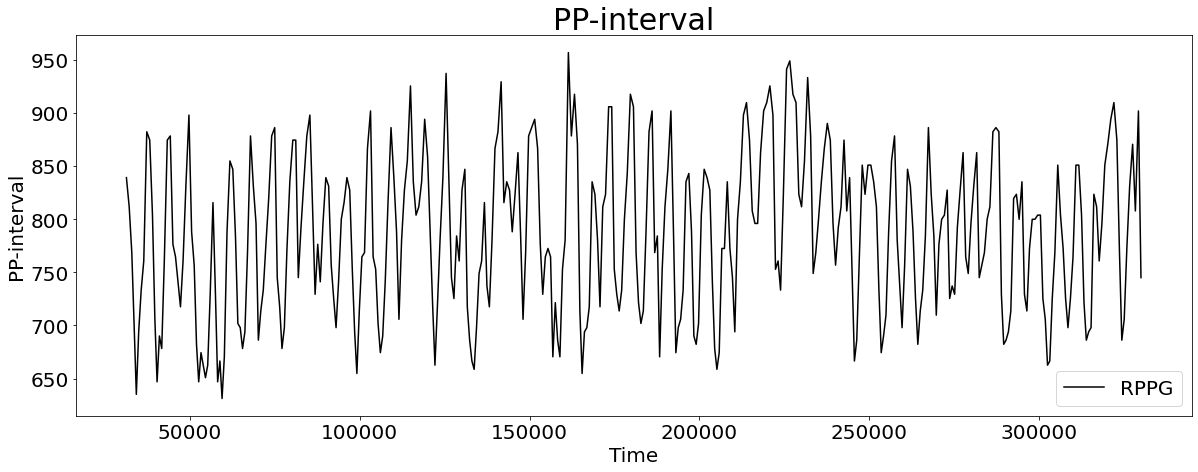

382 382


In [7]:
from scipy.stats import zscore
import matplotlib as mlp
cppg_ppi=np.diff(c_peaks_x)
rppg_ppi=np.diff(r_peaks_x)

plt.figure(figsize=(20, 7))    
#plt.plot(c_peaks_x[1:],cppg_ppi,label='CPPG',color='blue')
plt.xlabel('Time',fontsize=20)
plt.ylabel('PP-interval',fontsize=20)
plt.title('PP-interval',fontsize=30)
plt.plot(r_peaks_x[1:],rppg_ppi,label='RPPG',color='black')
mlp.rcParams["font.size"] = 20
#plt.xlim([290000,320000])
plt.legend(loc='lower right')
plt.show()
print(len(cppg_ppi),len(rppg_ppi))

## NNI extract

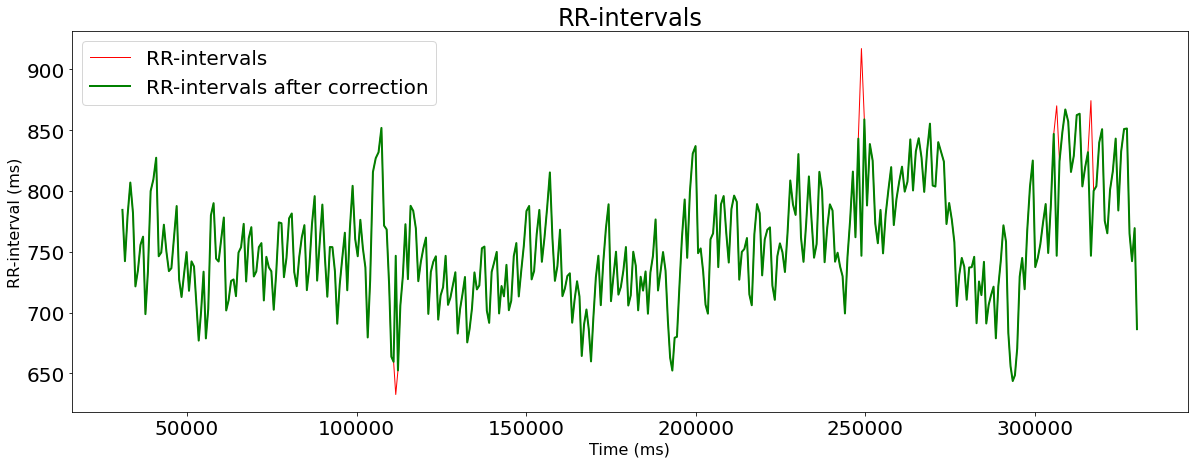

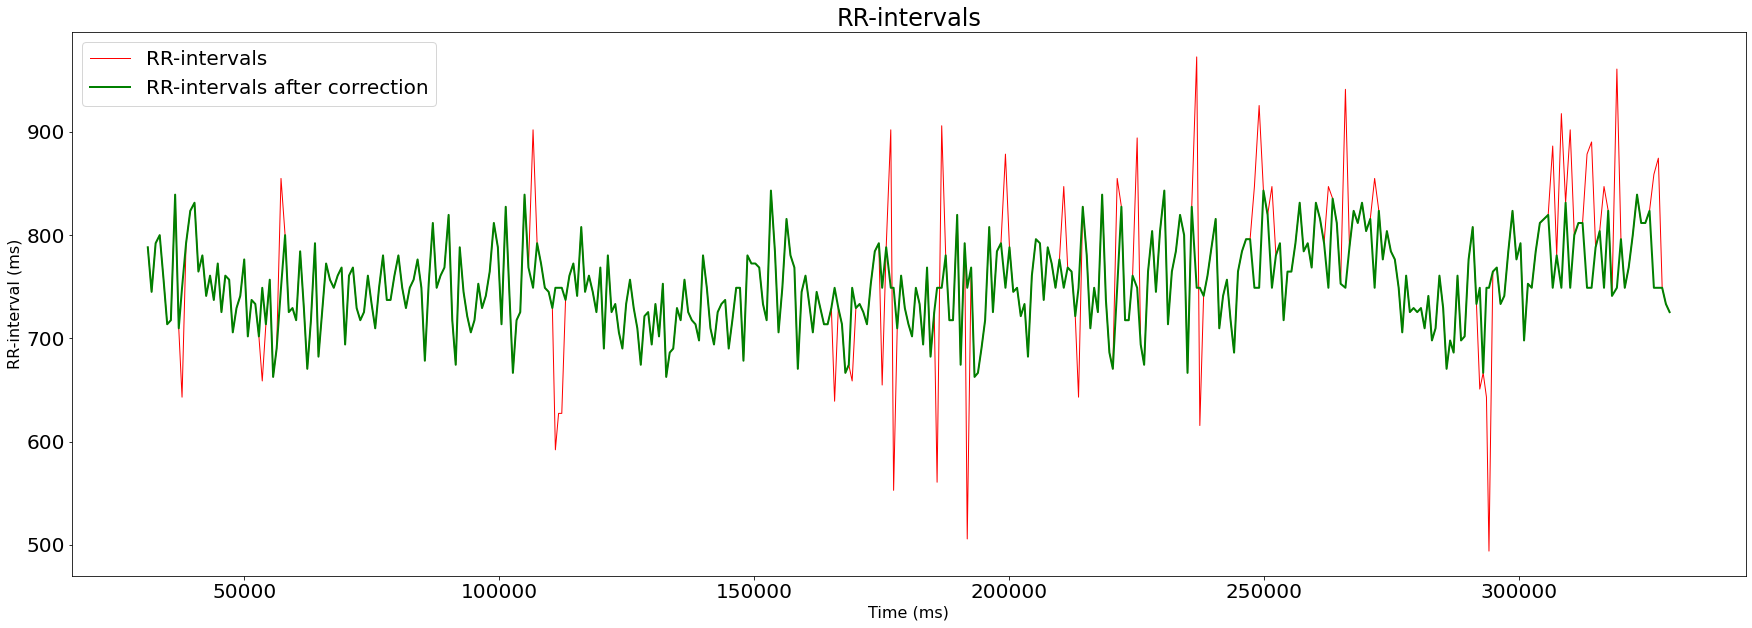

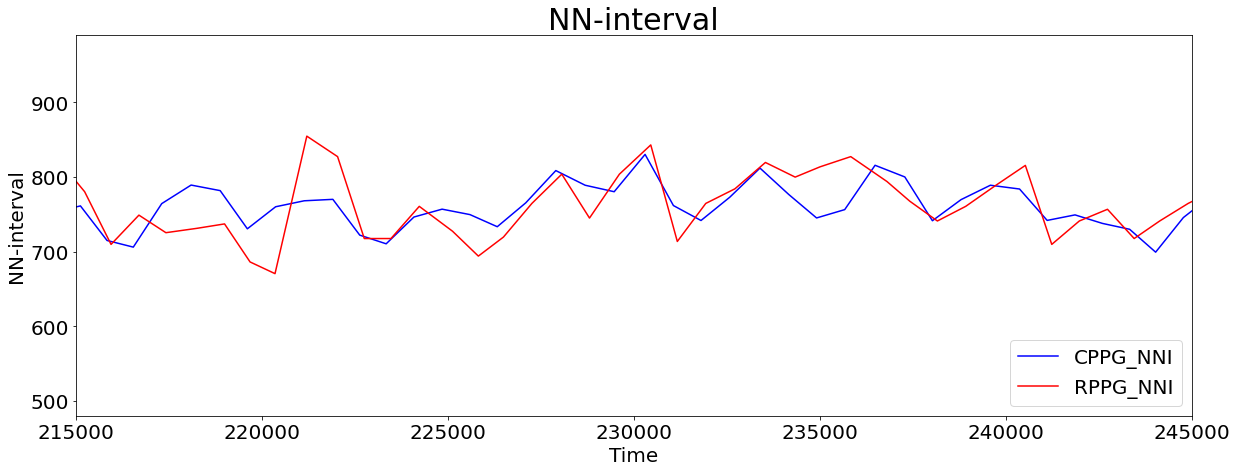

398 397


In [70]:
# new outlier 제거
from scipy.stats import zscore 
#cppg
plt.figure(figsize=(20, 7))    

c_nni = cppg_ppi.copy()
c_nni[np.abs(zscore(cppg_ppi)) > 2.5] = np.median(cppg_ppi)

plt.title("RR-intervals", fontsize=24)
plt.xlabel("Time (ms)", fontsize=16)
plt.ylabel("RR-interval (ms)", fontsize=16)

plt.plot(c_peaks_x[1:],cppg_ppi, color="red", linewidth=1, label="RR-intervals")
plt.plot(c_peaks_x[1:],c_nni, color="green", linewidth=2, label="RR-intervals after correction")
plt.legend(fontsize=20)
#plt.xlim([150000,200000])
plt.show()

# plt.figure(figsize=(20, 7))    
# plt.plot(c_nni)
# plt.show()


#rppg
plt.figure(figsize=(30, 10))    

r_nni = rppg_ppi.copy() 
r_nni[abs(zscore(rppg_ppi)) > 1.5] = np.median(rppg_ppi)

plt.title("RR-intervals", fontsize=24)
plt.xlabel("Time (ms)", fontsize=16)
plt.ylabel("RR-interval (ms)", fontsize=16)

plt.plot(r_peaks_x[1:],rppg_ppi, color="red", linewidth=1, label="RR-intervals")
plt.plot(r_peaks_x[1:],r_nni, color="green", linewidth=2, label="RR-intervals after correction")
plt.legend(fontsize=20)
#plt.xlim([150000,200000])
plt.show()


plt.figure(figsize=(20, 7))    
plt.plot(c_peaks_x[1:],cppg_nni,label='CPPG_NNI',color='blue')
plt.xlabel('Time',fontsize=20)
plt.ylabel('NN-interval',fontsize=20)
plt.title('NN-interval',fontsize=30)
plt.plot(r_peaks_x[1:],rppg_nni,label='RPPG_NNI',color='red')
mlp.rcParams["font.size"] = 20
plt.ylim([480,990])
plt.xlim([215000,245000])
plt.legend(loc='lower right')
plt.show()


print(len(c_nni),len(r_nni))

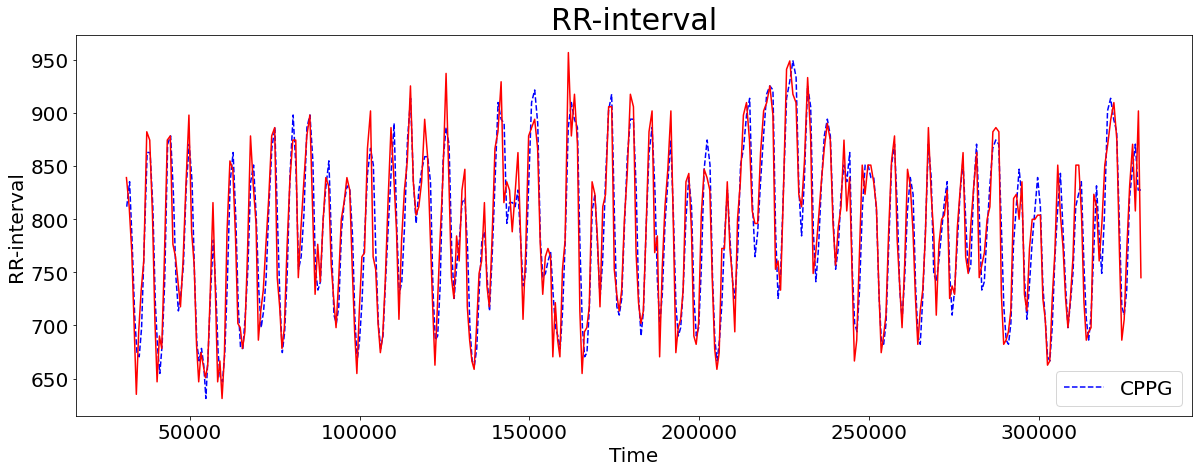

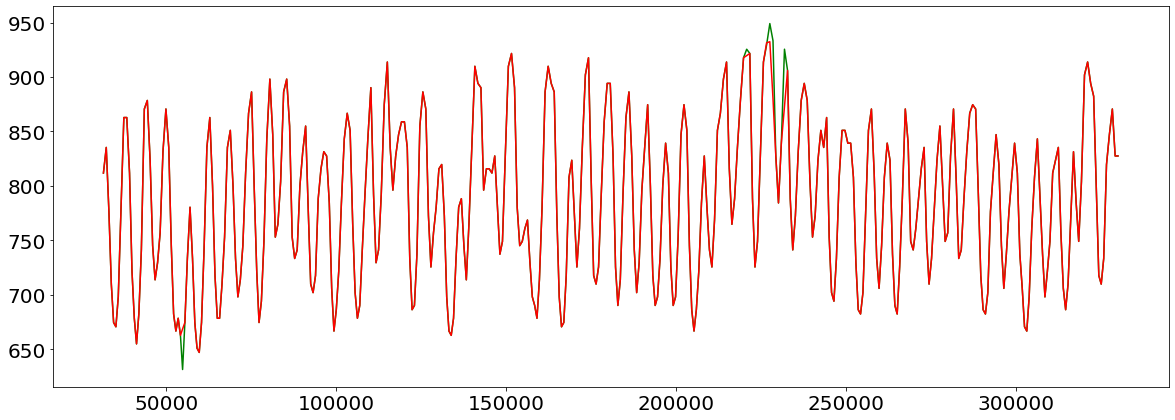

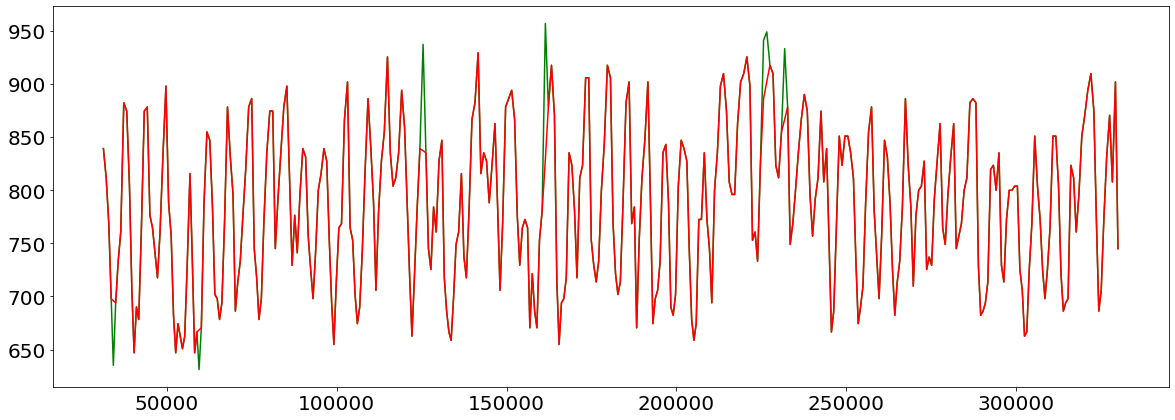

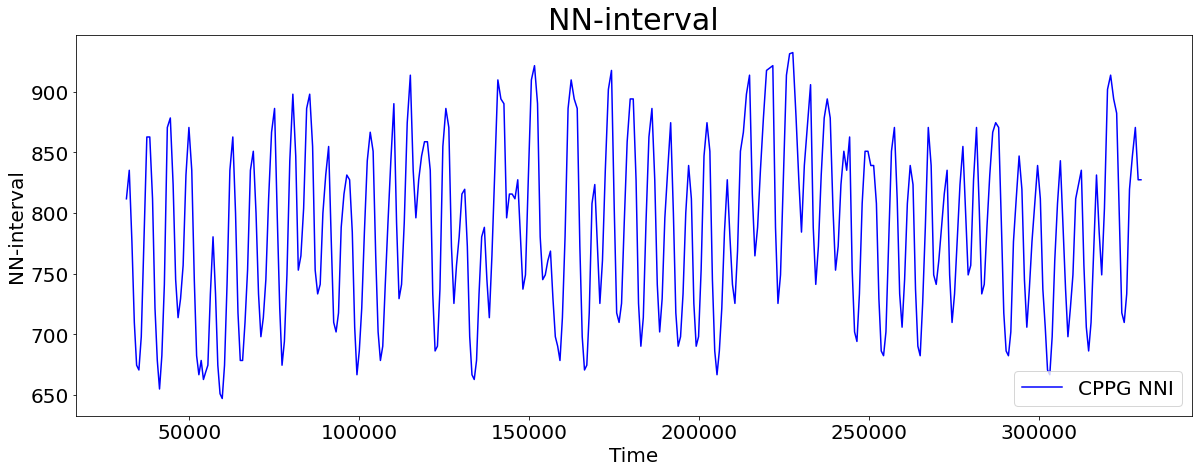

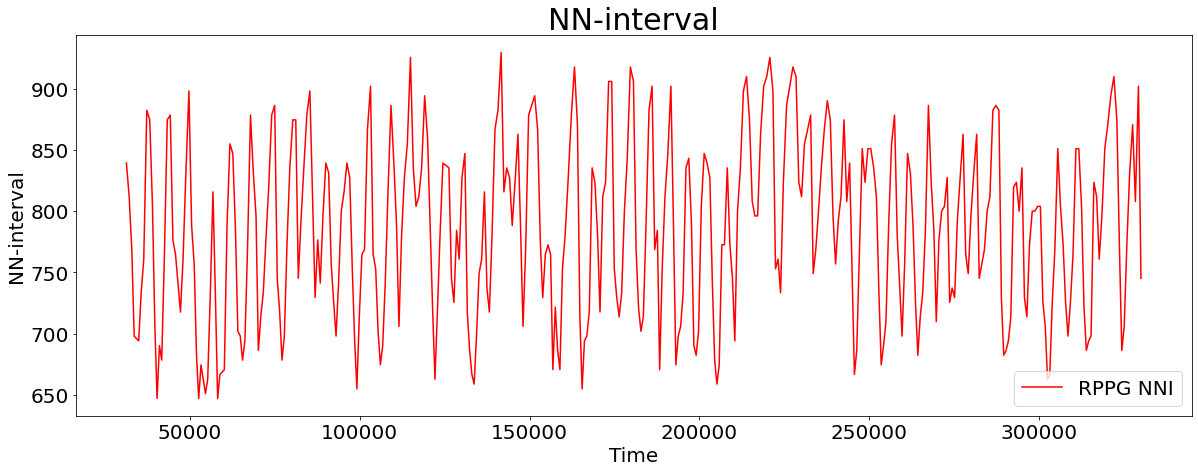

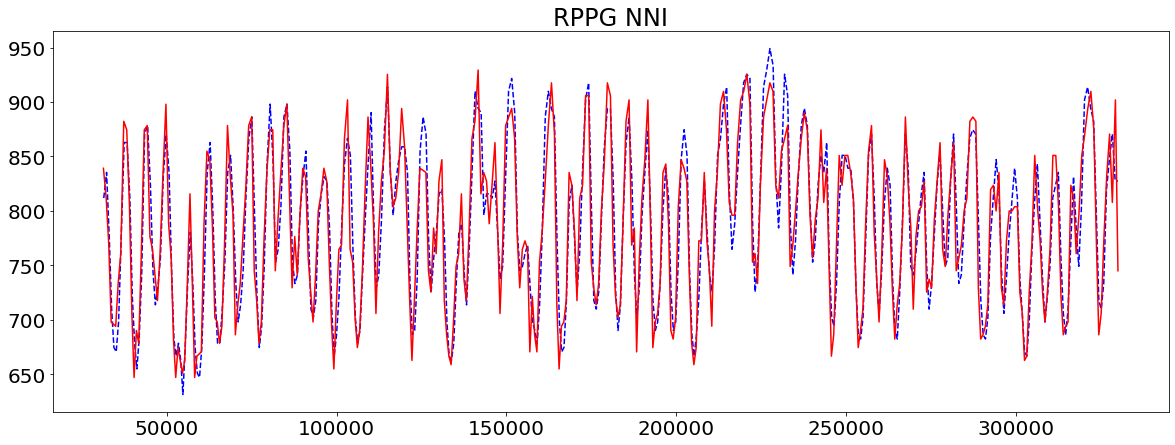

In [6]:
# locality median
from scipy.stats import zscore 

def local_NNI(windowsize,th, peaks_x, ppi):
    i = peaks_x[0]
    nni=ppi.copy()
    plt.figure(figsize=(20,7))
    plt.plot(peaks_x,nni,color='green')
    while (i <= peaks_x[-1]):
        start_idx = np.where(peaks_x >= i)
        end_idx = np.where(peaks_x <= i + windowsize)

        start = start_idx[0][0]
        end = end_idx[0][-1]
        #print("start-end", start, end)
        nni_part = nni[start:end + 1]
        idx=np.where(abs(zscore(nni[start:end + 1])) > th)
        if len(idx[0])>0 :
            for x in idx[0]:
                if x==0:
                    nni_part[x]=(nni_part[x]+nni_part[x+1])/2
                elif x+1>=len(nni_part):
                    nni_part[x]=(nni_part[x-1]+nni_part[x])/2
                else:
                    nni_part[x]=(nni_part[x-1]+nni_part[x+1])/2
                    #nni_part[x]=(nni_part[x-1]+nni_part[x+1]+nni_part[x])/3
        nni[start:end + 1] = nni_part
        i = i + windowsize
    plt.plot(peaks_x,nni,color='red')
    plt.show()
    return nni


cppg_ppi=np.diff(c_peaks_x)
rppg_ppi=np.diff(r_peaks_x)

plt.figure(figsize=(20, 7))
plt.plot(c_peaks_x[1:],cppg_ppi,label='CPPG',color='blue',linestyle='--')
plt.xlabel('Time',fontsize=20)
plt.ylabel('RR-interval',fontsize=20)
plt.title('RR-interval',fontsize=30)
plt.legend(loc='lower right')

plt.plot(r_peaks_x[1:],rppg_ppi,label='RPPG',color='red')
mlp.rcParams["font.size"] = 20

plt.show()

# rppg
windowsize=300000 # 60초
th=2
cppg_nni=local_NNI(windowsize,th,c_peaks_x[1:],cppg_ppi)
rppg_nni=local_NNI(windowsize,th,r_peaks_x[1:],rppg_ppi)

# plt.figure(figsize=(20,7))
# plt.plot(c_peaks_x[1:],cppg_nni,color='red')
# plt.plot(c_peaks_x[1:],cppg_ppi,color='blue',linestyle='--')

plt.figure(figsize=(20,7))
plt.xlabel('Time',fontsize=20)
plt.ylabel('NN-interval',fontsize=20)
plt.title('NN-interval',fontsize=30)
plt.plot(c_peaks_x[1:],cppg_nni,label='CPPG NNI',color='blue')#,linestyle='--'
plt.legend(loc='lower right')
mlp.rcParams["font.size"] = 20
plt.show()

plt.figure(figsize=(20,7))
plt.xlabel('Time',fontsize=20)
plt.ylabel('NN-interval',fontsize=20)
plt.title('NN-interval',fontsize=30)
plt.plot(r_peaks_x[1:],rppg_nni,label='RPPG NNI',color='red')
plt.legend(loc='lower right')
mlp.rcParams["font.size"] = 20
plt.show()


plt.show()

plt.figure(figsize=(20,7))
plt.title('RPPG NNI')
plt.plot(c_peaks_x[1:],cppg_ppi,color='blue',linestyle='--')
plt.plot(r_peaks_x[1:],rppg_nni,color='red')

plt.show()

R score- 0.32512959390450635


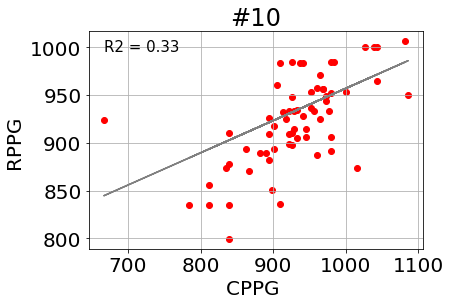

In [872]:
# NNI 일치율 구하기
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import numpy as np
r=rppg_ppi.reshape([-1,1])
c=cppg_ppi.reshape([-1,1])

trainx,testx,trainy,testy=train_test_split(r[:],c[:],test_size=0.2,shuffle=True,random_state=59)

model=LinearRegression()
model.fit(trainx,trainy)
y_pred=model.predict(testx)
y_true=testy
print("R score-" ,r2_score(y_true,y_pred))

#plt.figure(figsize=(5,5))
plt.title("#10")
plt.text(min(testx),max(testy)-10, 'R2 = {0:0.2f}'.format(r2_score(y_true,y_pred)), fontsize=15, color='black')
plt.xlabel('CPPG ')
plt.ylabel('RPPG ')
plt.scatter(testx,testy,color='red')
plt.grid(True)
plt.plot(testx,y_pred,color='gray')
#plt.savefig('nni_regression_10-10')
plt.show()

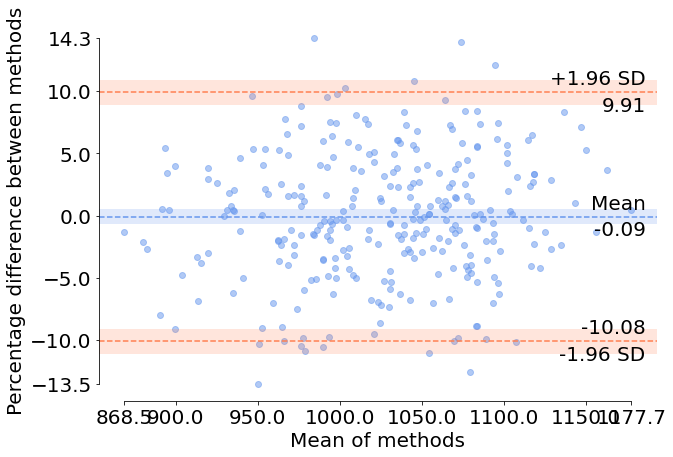

[940.5078125 912.765625 ]
[858.73930011 937.16298048]


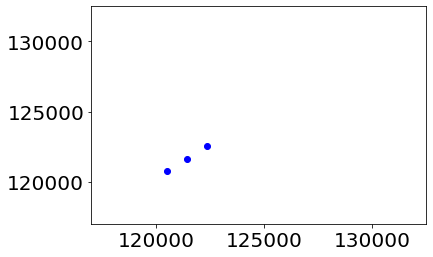

In [1130]:
from pyCompare import blandAltman 
blandAltman(rppg_nni, cppg_nni,
            limitOfAgreement=1.96,
            confidenceInterval=95,
            confidenceIntervalMethod='approximate',
            detrend=None,
            percentage=True)
print(np.diff(c_peaks_x[:3]))
print(np.diff(r_peaks_x[:3]))
#plt.scatter(cppg_nni[:],rppg_nni,color='red')
plt.plot([0,0],[100000,100000],color='red')
plt.scatter(c_peaks_x[:3],r_peaks_x[:3],color='blue')
plt.xlim(117000,132500)
plt.ylim(117000,132500)
plt.show()

# hrv features

In [903]:
import pandas as pd
from pandas import DataFrame

cppg_frequency_feature = get_frequency_domain_features(cppg_nni)#cppg_ppi c_nni
rppg_frequency_feature = get_frequency_domain_features(rppg_nni)#rppg_ppi r_nni

cppg_time_feature = get_time_domain_features(cppg_nni)
rppg_time_feature=get_time_domain_features(rppg_nni)

# plt.bar(['cppg_Lf','cppg_Hf','rppg_Lf','rppg_Hf'],[cppg_frequency_feature['lf'],cppg_frequency_feature['hf'],rppg_frequency_feature['lf'],rppg_frequency_feature['hf']])
# plt.title('diff')
# plt.show()

# data={'LF':[cppg_frequency_feature['lf'],rppg_frequency_feature['lf'],cppg_frequency_feature['lf']-rppg_frequency_feature['lf']],
#         'HF':[cppg_frequency_feature['hf'],rppg_frequency_feature['hf'],cppg_frequency_feature['hf']-rppg_frequency_feature['hf']],
#      'diff':[cppg_frequency_feature['hf']-cppg_frequency_feature['lf'],rppg_frequency_feature['hf']-rppg_frequency_feature['lf'],"-"]}
# frame=DataFrame(data,index=['cppg','rppg','c-r diff'])

# print("================================================================================================")

# print("c의 lf는 r보다 (c_lf / r_lf =) ",cppg_frequency_feature['lf']/ rppg_frequency_feature['lf'],"배 크다")
# print("c의 hf는 r보다 (c_hf / r_hf =) ",cppg_frequency_feature['hf']/rppg_frequency_feature['hf'],"배 크다")


# print("================================================================================================")
# print("r의 lf는 c보다 (r_lf / c_lf =) ",rppg_frequency_feature['lf']/ cppg_frequency_feature['lf'],"배 크다")
# print("r의 hf는 c보다 (r_hf / c_hf =) ",rppg_frequency_feature['hf']/ cppg_frequency_feature['hf'],"배 크다")
# print("r의 lf는 c보다 (r_lf - c_lf =)",rppg_frequency_feature['lf'] - cppg_frequency_feature['lf'],"만큼 크다")
# print("r의 hf는 c보다 (r_hf - c_hf =)",rppg_frequency_feature['hf'] - cppg_frequency_feature['hf'],"만큼 크다")
# print("배율: ", (rppg_frequency_feature['lf']/ cppg_frequency_feature['lf'])/(rppg_frequency_feature['hf']/ cppg_frequency_feature['hf']) )
# print("================================================================================================")
# print("r의 hf는 lf와 비교했을때 ((r_hf - c_hf) / (r_lf - c_lf) = )", abs(rppg_frequency_feature['hf']-cppg_frequency_feature['hf'])/abs(rppg_frequency_feature['lf']- cppg_frequency_feature['lf']),"배 차이가 크다")
# print("c의 hf는 lf와 비교했을때 ((c_hf - r_hf) / (c_lf - r_lf) = )", abs(cppg_frequency_feature['hf']-rppg_frequency_feature['hf'])/abs(cppg_frequency_feature['lf']- rppg_frequency_feature['lf']),"배 차이가 크다")

# print("================================================================================================")
# print("lf_hf_ratio: ",cppg_frequency_feature['lf_hf_ratio'],rppg_frequency_feature['lf_hf_ratio'] )
# frame

In [904]:
# print(cppg_frequency_feature)
# print(rppg_frequency_feature)
print(cppg_time_feature)
print(rppg_time_feature)

{'mean_nni': 936.4588313087775, 'sdnn': 35.94510029287738, 'sdsd': 44.137467049863204, 'nni_50': 94, 'pnni_50': 29.46708463949843, 'nni_20': 254, 'pnni_20': 79.62382445141066, 'rmssd': 44.13769741508611, 'median_nni': 937.15625, 'range_nni': 171.2421875, 'cvsd': 0.04713255504611995, 'cvnni': 0.038384068889223, 'mean_hr': 64.16558076763107, 'max_hr': 70.18249275786127, 'min_hr': 58.47062764564363, 'std_hr': 2.4664341514013843}
{'mean_nni': 934.6793086495138, 'sdnn': 53.51328868621966, 'sdsd': 75.4428021635937, 'nni_50': 162, 'pnni_50': 50.625, 'nni_20': 236, 'pnni_20': 73.75, 'rmssd': 75.44337896471816, 'median_nni': 935.2023884707596, 'range_nni': 326.4385695605888, 'cvsd': 0.08071579018232866, 'cvnni': 0.057253100813303745, 'mean_hr': 64.40693276341679, 'max_hr': 81.06755336713526, 'min_hr': 56.25551727222825, 'std_hr': 3.7532994839199634}


# 결과 csv로 저장

In [94]:
cppg_frequency_feature['num'] = "cppg"+str(subject) + "_" + str(num)
rppg_frequency_feature['num'] = "rppg"+str(subject) + "_" + str(num)

In [809]:
save_path="D:\\prlab\\ysg\\rppg\\RPPG-HRV_analysis\\%d.csv"%subject
with open(save_path, 'a', newline='') as f:
    wr = csv.writer(f)
    if num==0:
        # 처음만 csv에 key 저장
        wr.writerow(cppg_time_feature.keys())
    wr.writerow(cppg_time_feature.values())
    wr.writerow(rppg_time_feature.values())
    f.close()